# <font style = "color:rgb(50,120,229)">Dlib’s 68-Points Model</font>

The image below shows all the landmarks and their corresponding indices in Dlib’s array. In many applications we are concerned with use only a few facial landmarks. In those cases, the figure below can be used for quick reference. In this notebook, we will show how to detect these points, plot them on a face image and save them to file. 

<center><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w3-m1-68pointModel.png" width=500/></center>

# <font style = "color:rgb(50,120,229)">Facial Landmark Detection in Dlib</font>

Landmark detection is a two step process.

## <font style="color:rgb(50,120,229)">Face Detection </font>
In the first step, you need to detect the face in an image. For best results we should use the same face detector used in training the landmark detector.  The output of a face detector is a rectangle (x, y, w, h) that contains the face. 

We have seen that OpenCV’s face detector is based on HAAR cascades. Dlib’s face detector is based on Histogram of Oriented Gradients features and Support Vector Machines (SVM). 


## <font style="color:rgb(50,120,229)">Landmark detection</font>
The landmark detector finds the landmark points inside the face rectangle. 


## <font style = "color:rgb(50,120,229)">Facial Landmark Detection Code</font>

In this section we will go step by step over the code for facial landmark detection on an image and save the results to disk. 

In [1]:
import dlib
import cv2
import numpy as np
from renderFace import renderFace
from dataPath import DATA_PATH
from dataPath import MODEL_PATH

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0,10.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

In [4]:
def writeLandmarksToFile(landmarks, landmarksFileName):
  with open(landmarksFileName, 'w') as f:
    for p in landmarks.parts():
      f.write("%s %s\n" %(int(p.x),int(p.y)))

  f.close()

In [5]:
# Landmark model location
PREDICTOR_PATH = MODEL_PATH + "shape_predictor_68_face_landmarks.dat"

## <font style="color:rgb(50,120,229)">Initialize the Face detector</font>

Dlib has a built-in face detector which can be accessed using **`get_frontal_face_detector()`**. Notice that we did not have to specify a model file for Dlib’s face detector because the face detector is built into the code.

In [6]:
# Get the face detector instance
faceDetector = dlib.get_frontal_face_detector()

## <font style="color:rgb(50,120,229)">Initialize the Landmark Predictor (a.k.a Shape predictor)</font>

The **`shape_predictor`** class implements Dlib’s facial landmark detector. As the name suggests, it can be used to detect other landmark points ( e.g. the four corners of a credit card ) when trained to do so. Load the facial landmark detector model file. The information in the file makes the generic **`shape_predictor`** - a facial landmark detector.

In [7]:
# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

# Read image
imageFilename = DATA_PATH + "images/family.jpg"
im= cv2.imread(imageFilename)

# landmarks will be stored in results/family_i.txt
landmarksBasename = "results/family"

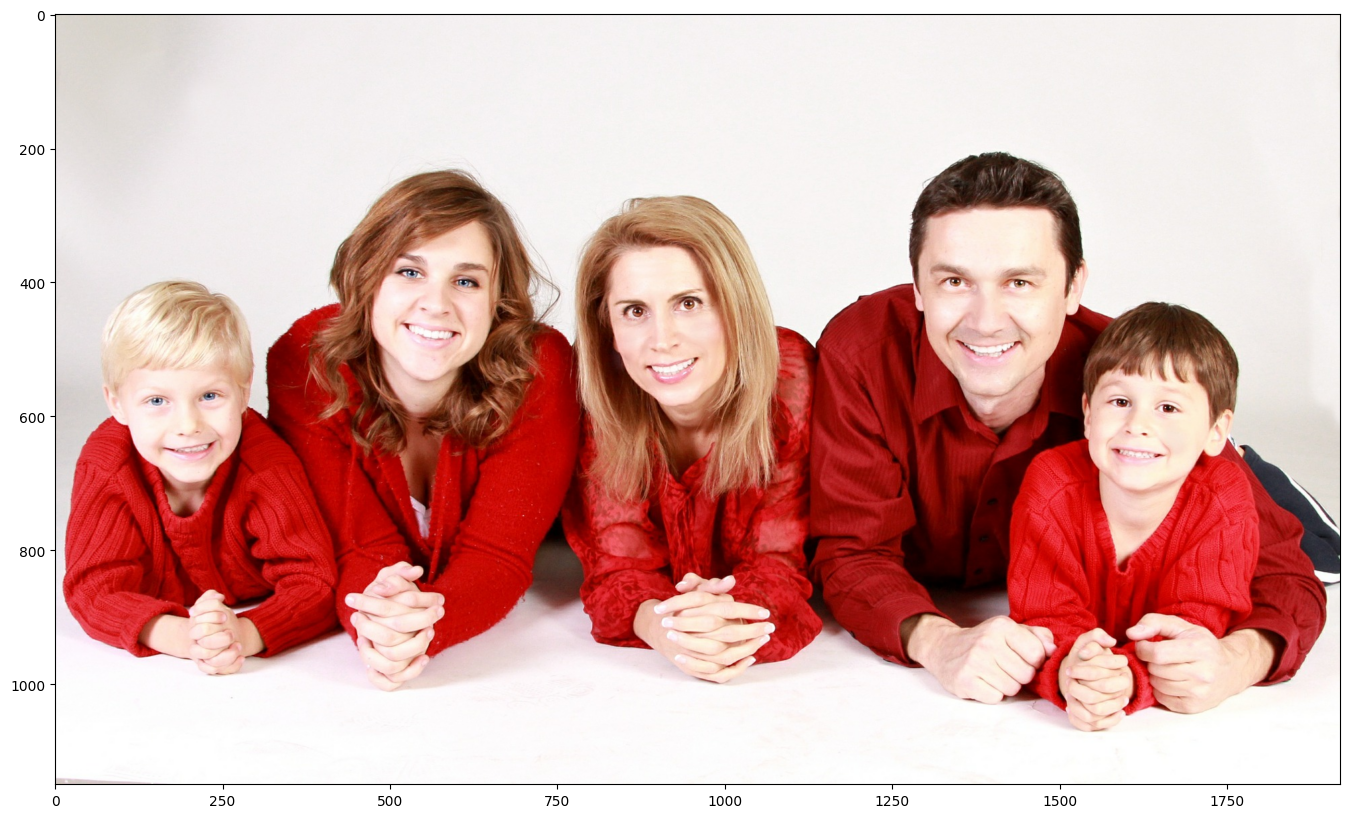

In [8]:
plt.imshow(im[:,:,::-1])
plt.show()

## <font style="color:rgb(50,120,229)">Detect Faces </font>

First, we need to detect faces by passing the image to Dlib’s face detector. In the example image, there are multiple faces. The 0 signifies that no upscaling is done. To detect small faces, you can upscale the image.

In [9]:
# Detect faces in the image
faceRects = faceDetector(im, 0)
print("Number of faces detected: ",len(faceRects))

# List to store landmarks of all detected faces
landmarksAll = []

Number of faces detected:  5


## <font style="color:rgb(50,120,229)">Detect landmarks for each face</font>

Next, we loop over all the face rectangles and perform landmark detection for every face.

Dlib’s landmark detector needs two inputs 
1. Input image. 
2. Face rectangle

The output landmarks are stored in an instance of the class full_object_detection. 

A few important methods of full_object_detection are listed below
1. `num_parts()` : Number of landmark points. 
2. `part(i)` : The ith landmark point
3. `part(i).x()` and `part(i).y()` can be used to access the x and y coordinates of the ith landmark point.
 
We will use these methods very frequently.

The `landmarkDetector` detects the landmarks and all the detected landmarks are stored in a list `landmarksAll`

In [19]:
# Loop over all detected face rectangles
for i in range(0, len(faceRects)):
  newRect = dlib.rectangle(int(faceRects[i].left()),
                          int(faceRects[i].top()),
                          int(faceRects[i].right()),
                          int(faceRects[i].bottom()))
  # For every face rectangle, run landmarkDetector
  landmarks = landmarkDetector(im, newRect)
  # Print number of landmarks
  if i==0:
    print("Number of landmarks",len(landmarks.parts()))

  # Store landmarks for current face
  landmarksAll.append(landmarks)

  # Next, we render the outline of the face using
  # detected landmarks.
  renderFace2(im, landmarks)

  # The code below saves the landmarks to 
  # results/family_0.txt … results/family_4.txt.
  landmarksFileName = landmarksBasename +"_"+ str(i)+ ".txt"
  print("Saving landmarks to", landmarksFileName)
  # Write landmarks to disk
  writeLandmarksToFile(landmarks, landmarksFileName)

Number of landmarks 68
Saving landmarks to results/family_0.txt
Saving landmarks to results/family_1.txt
Saving landmarks to results/family_2.txt
Saving landmarks to results/family_3.txt
Saving landmarks to results/family_4.txt


The output image is saved to `results/familyLandmarks.jpg`

In [20]:
outputFileName = "results/familyLandmarks.jpg"
print("Saving output image to", outputFileName)
cv2.imwrite(outputFileName, im)

Saving output image to results/familyLandmarks.jpg


True

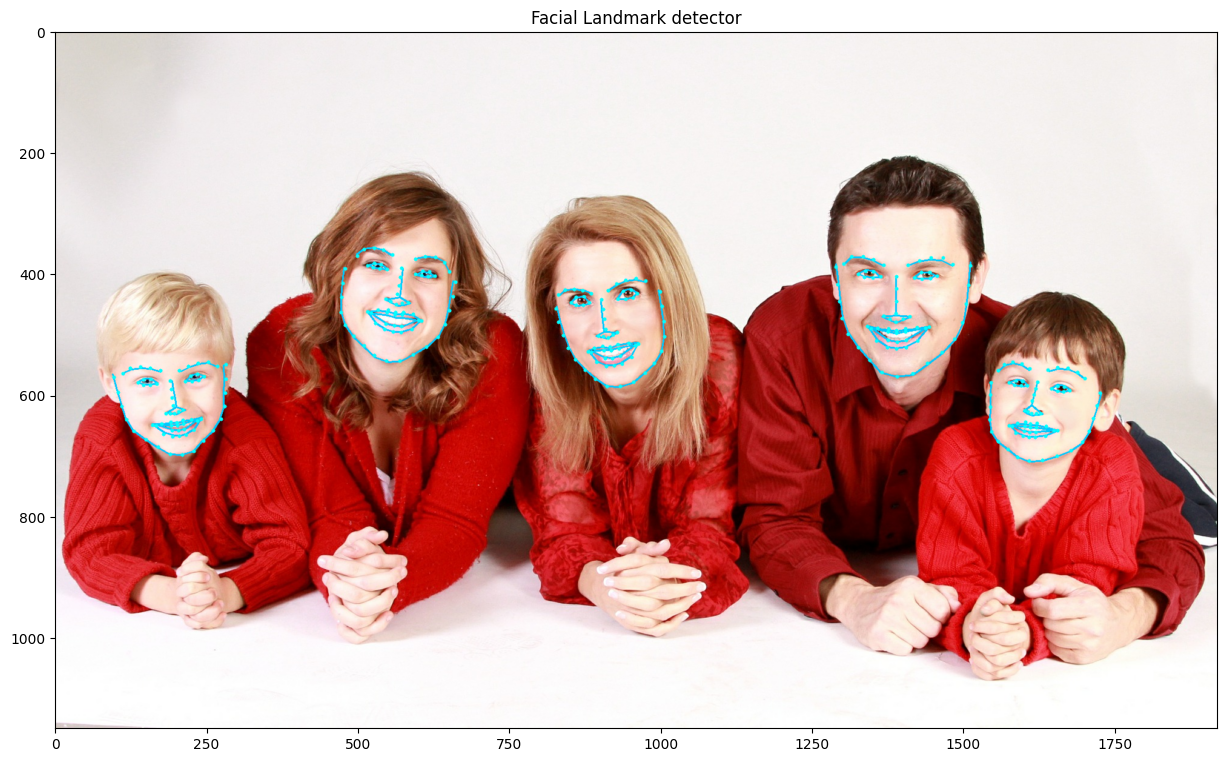

In [21]:
plt.figure(figsize=(15,15))
plt.imshow(im[:,:,::-1])
plt.title("Facial Landmark detector")
plt.show()

You can view the full resolution image [here](https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w3-m1-outputlandMark.png)

## <font style = "color:rgb(50,120,229)">Rendering Facial Landmarks</font>

In this section, we will go over the code used for displaying landmarks on the face. There are two different rendering methods. 

1. **Draws outline:** For Dlib’s 68-point model, we draw the outline of the face using open and closed polygons. In OpenCV, this is done using the function polylines().

2. **Draws points:** For models the number of points is not 68, we have written a generic renderer that simply displays all the points as dots. 

Let us dive into the code to see the implementation. 

The `drawPolyline` function shown below takes in an image and landmarks as input.

The x and y coordinates of the ith point is accessed using `landmarks.part(i).x` and `landmarks.part(i).y` respectively.

The landmark points are copied to a numpy array and cv2.polylines is used to draw the lines on the image connecting landmarks at index start and index end.

The usage of polylines is shown below:

```python
img	=	cv.polylines(	img, pts, isClosed, color[, thickness[, lineType[, shift]]]	)
```

Where,

- **`img`** - Image.
- **`pts`** - Array of polygonal curves.
- **`isClosed`** - Flag indicating whether the drawn polylines are closed or not. If they are closed, the function draws a line from the last vertex of each curve to its first vertex.
- **`color`** - Polyline color.
- **`thickness`** - Thickness of the polyline edges.
- **`lineType`** - Type of the line segments. See LineTypes
- **`shift`** - Number of fractional bits in the vertex coordinates.

In [13]:
def drawPolyline(im, landmarks, start, end, isClosed=False):
  points = []
  for i in range(start, end+1):
    point = [landmarks.part(i).x, landmarks.part(i).y]
    points.append(point)

  points = np.array(points, dtype=np.int32)
  cv2.polylines(im, [points], isClosed, (255, 200, 0), 
                  thickness=2, lineType=cv2.LINE_8)

In [14]:
# Use this function for 68-points facial landmark detector model
def renderFace(im, landmarks):
    assert(landmarks.num_parts == 68)
    drawPolyline(im, landmarks, 0, 16)           # Jaw line
    drawPolyline(im, landmarks, 17, 21)          # Left eyebrow
    drawPolyline(im, landmarks, 22, 26)          # Right eyebrow
    drawPolyline(im, landmarks, 27, 30)          # Nose bridge
    drawPolyline(im, landmarks, 30, 35, True)    # Lower nose
    drawPolyline(im, landmarks, 36, 41, True)    # Left eye
    drawPolyline(im, landmarks, 42, 47, True)    # Right Eye
    drawPolyline(im, landmarks, 48, 59, True)    # Outer lip
    drawPolyline(im, landmarks, 60, 67, True)    # Inner lip

The following version of `renderFace` is used for displaying landmark points as dots. The landmarks need to be supplied as a numpy array of landmark points. You can choose the color and size (radius) of the dot.

In [17]:
# Use this function for any model other than
# 68 points facial_landmark detector model
def renderFace2(im, landmarks, color=(255, 255, 0), radius=3):
  for p in landmarks.parts():
    cv2.circle(im, (p.x, p.y), radius, color, -1)

## <font style = "color:rgb(50,120,229)">Writing Facial Landmarks to Disk </font>

The landmarks are written to disk by accessing the x and y coordinates of the ith point using `landmarks.part(i).x()` and `landmarks.part(i).y()` respectively. 

The code below shows how to write landmarks to a file. An output file stream is opened and the `(x, y)` coordinates of a point are written with a space in between them. Each row contains one point. Here we iterate over the parts of the landmarks and access the x and y coordinate as `p.x` and `p.y` respectively

In [18]:
def writeLandmarksToFile(landmarks, landmarksFileName):
    with open(landmarksFileName, 'w') as f:
        for p in landmarks.parts():
            f.write("%s %s\n" %(int(p.x),int(p.y))) 
    f.close()

# <font style = "color:rgb(50,120,229)">References and Further Reading</font>

[http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html](http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html)

[http://dlib.net/face_landmark_detection_ex.cpp.html](http://dlib.net/face_landmark_detection_ex.cpp.html)

[http://dlib.net/face_landmark_detection.py.html](http://dlib.net/face_landmark_detection.py.html)

[http://www.learnopencv.com/facial-landmark-detection](http://www.learnopencv.com/facial-landmark-detection)

[http://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python](http://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python)

[https://developers.google.com/vision/](https://developers.google.com/vision/)